# Модель ARIMA
Это модель авторегрессии с интегрированием и скользящим средним порядков (𝑝, 𝑑, 𝑞),является суммой 𝐴𝑅(𝑝) и 𝑀𝐴(𝑞) моделей и может быть представлена в виде
𝐴𝑅𝐼𝑀𝐴(𝑝,𝑑,𝑞):(1−𝜙1𝐿−⋯−𝜙𝑝𝐿𝑝)((1–𝐿)𝑑𝑦𝑡 −𝜇)=(1+𝜃1𝐿+⋯+𝜃𝑞𝐿𝑞)𝜀𝑡,
где 𝑑 – количество дифференцирований исходного временного ряда до достижения его
стационарности, а 𝐿 – величина лага.
Модель авторегрессии порядка 𝑝 описывается как
𝐴𝑅(𝑝): 𝑦𝑡 = 𝑐 + 𝜙1𝑦(𝑡−1) + 𝜙2𝑦(𝑡−2) + ⋯ + 𝜙𝑝𝑦(𝑦−𝑝) + 𝜀𝑡
и показывает зависимость значения нынешнего периода от прошлых значений p- периодов,
Модель скользящего среднего порядка 𝑞 описывается как
𝑀𝐴(𝑞): 𝑦𝑡 = 𝑐 + 𝜀𝑡 + 𝜃1𝜀(𝑡−1) + 𝜃2𝜀(𝑡−2) + ⋯ + 𝜃𝑞𝜀(𝑡−𝑞)
и показывает зависимость значения нынешнего периода от ошибок предсказания предыдущих 𝑞 периодов.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.rc('figure', figsize=(18,6))
plt.style.use('Solarize_Light2')

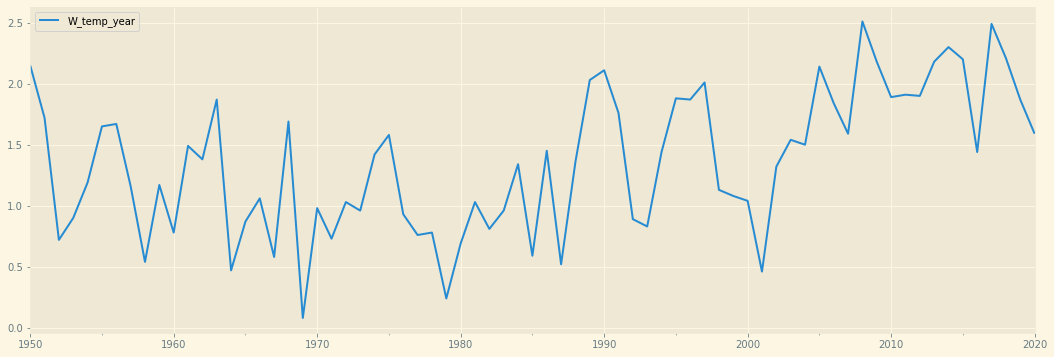

In [2]:
year_raw = pd.read_pickle('./year_raw.pkl')
data = year_raw['W_temp_year']
data.index = pd.to_datetime(data.index, format='%Y')
data = pd.DataFrame(data)
data.plot()

In [3]:
data['rolling_data'] = data.W_temp_year.rolling(window=4).mean()

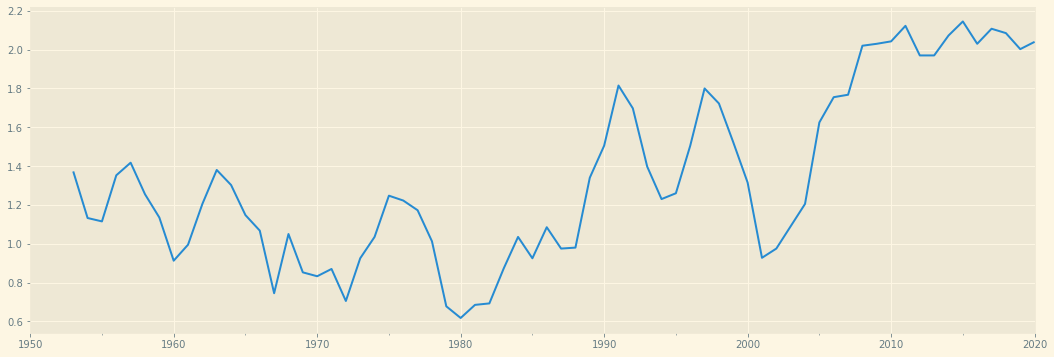

In [4]:
data['rolling_data'].plot()

In [5]:
data

,W_temp_year,rolling_data
1950-01-01,2.15,NaN
1951-01-01,1.72,NaN
1952-01-01,0.72,NaN
1953-01-01,0.90,1.3725
1954-01-01,1.19,1.1325
...,...,...
2016-01-01,1.44,2.0300
2017-01-01,2.49,2.1075
2018-01-01,2.21,2.0850
2019-01-01,1.87,2.0025


In [6]:
data = data['rolling_data'].dropna()

In [7]:
# calculate stationarity test of time series data
from statsmodels.tsa.stattools import adfuller

result = adfuller(data.values, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for k, v in result[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<result[0] else "", 100-int(k[:-1])))
    

# calculate stationarity test of difference time series data
data_diff = data.diff()
data_diff = data_diff.dropna()
result_diff = adfuller(data_diff.values, autolag='AIC')
print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])
print('Critical Values:')
for k, v in result_diff[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<result_diff[0] else "", 100-int(k[:-1])))

ADF Statistic: -0.120766
p-value: 0.947330
Critical Values:
	1%: -3.5463945337644063 - The data is not stationary with 99% confidence
	5%: -2.911939409384601 - The data is not stationary with 95% confidence
	10%: -2.5936515282964665 - The data is not stationary with 90% confidence
ADF Statistic: -3.939644
p-value: 0.001762
Critical Values:
	1%: -3.5463945337644063 - The data is  stationary with 99% confidence
	5%: -2.911939409384601 - The data is  stationary with 95% confidence
	10%: -2.5936515282964665 - The data is  stationary with 90% confidence


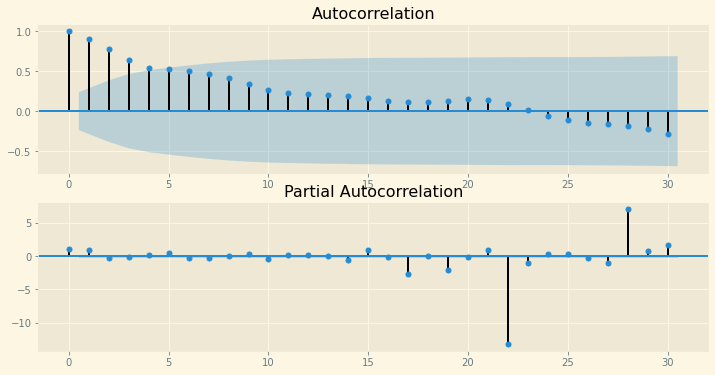

In [8]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(data, ax=ax[0], lags=30)
ax[1] = plot_pacf(data, ax=ax[1], lags=30)

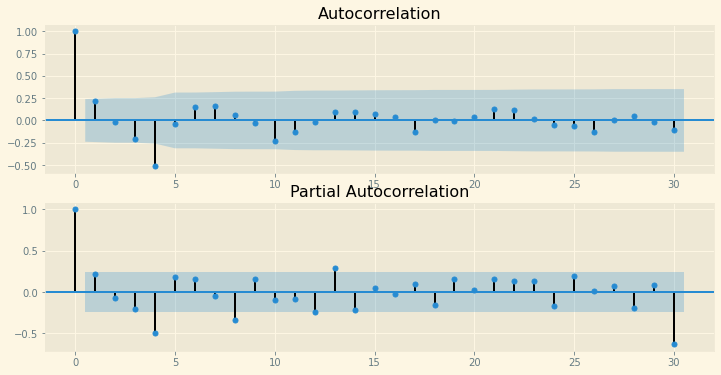

In [9]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(data_diff, ax=ax[0], lags=30)
ax[1] = plot_pacf(data_diff, ax=ax[1], lags=30)

# Тестирование базовой модели ARIMA(1,1,1)

In [10]:
# # split into train and test sets
# X = data.values
# size = int(len(X) * 0.66)
# train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]

# # walk-forward validation
# predictions = []
# for t in range(len(test)):
#     model_114 = ARIMA(history, order=(1,1,1))
#     model_114_fit = model_114.fit()
#     output = model_114_fit.forecast()
#     yhat = output[0]
#     predictions.append(yhat)
#     obs = test[t]
#     history.append(obs)
#     #print('predicted=%f, expected=%f' % (yhat, obs))

# #residuals describe
# residuals = [test[i]-predictions[i] for i in range(len(test))]
# residuals = pd.DataFrame(residuals)
# print(residuals.describe())

# residuals.plot(kind='kde')

# model_114_fit.summary()

In [11]:
# # report performance
# rmse = sqrt(mean_squared_error(test, predictions))
# print('RMSE: %.3f' % rmse)

# # report performance with predictions bias
# bias = 0.02
# predictions_bias = [bias + i for i in predictions]
# rmse_bias = sqrt(mean_squared_error(test, predictions_bias))
# print('RMSE: %.3f' % rmse)

# Grid search Arima hyper parametrs

In [12]:
# from sklearn.metrics import mean_squared_error
# from statsmodels.tsa.arima.model import ARIMA
# from math import sqrt

# # evaluate an ARIMA model for a given order (p,d,q)
# def evaluate_arima_model(X, arima_order):
#     # prepare training dataset
#     train_size = int(len(X) * 0.66)
#     train, test = X[0:train_size], X[train_size:]
#     history = [x for x in train]

#     # make predictions
#     predictions = list()
#     for t in range(len(test)):
#         model = ARIMA(history, order=arima_order)
#         model_fit = model.fit()
#         yhat = model_fit.forecast()[0]
#         predictions.append(yhat)
#         history.append(test[t])
#     # calculate out of sample error
#     rmse = np.sqrt(mean_squared_error(test, predictions))
#     aic = model_fit.aic
#     return rmse, aic


# # evaluate combinations of p, d and q values for an ARIMA model
# def evaluate_models(dataset, p_values, d_values, q_values):
#     dataset = dataset.astype('float32')
#     best_score, best_cfg, best_aic, best_aic_cfg = float("inf"), None, float("inf"), None
#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 order = (p,d,q)
#                 try:
#                     result = evaluate_arima_model(dataset, order)
#                     rmse = result[0]
#                     aic = result[1]
#                     #print(rmse[0])
#                     if rmse < best_score:
#                         best_score, best_cfg = rmse, order
#                     if aic < best_aic:
#                         best_aic, best_aic_cfg = aic, order
#                     print('ARIMA%s RMSE=%.3f AIC=%.3f' % (order,rmse, aic))
#                 except:
#                     continue
    
#     print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
#     print('Best AIC=%.3f ARIMA%s' % (best_aic, best_aic_cfg))
    

# import warnings
# warnings.filterwarnings("ignore")

# X = data.values
# # evaluate parameters
# p_values = range(1,15)
# d_values = range(1,3)
# q_values = range(1,15)

# evaluate_models(data.values, p_values, d_values, q_values)

# Best ARIMA(0, 1, 4) RMSE=0.119
# Best ARIMA(6, 2, 7) RMSE=0.119
# Best AIC=-73.894 ARIMA(5, 1, 3)

# Best ARIMA(0, 1, 4) RMSE=0.119
# Тестирование выбранной модели ARIMA(0,1,4)

In [13]:
# # split into train and test sets
# X = data.values
# size = int(len(X) * 0.66)
# train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]

# # walk-forward validation
# predictions_014 = []
# for t in range(len(test)):
#     model_014 = ARIMA(history, order=(0,1,4))
#     fit_014 = model_014.fit()
#     output = fit_014.forecast()
#     yhat = output[0]
#     predictions_014.append(yhat)
#     obs = test[t]
#     history.append(obs)
#     #print('predicted=%f, expected=%f' % (yhat, obs))

# #residuals describe
# residuals_014 = [test[i]-predictions_014[i] for i in range(len(test))]
# residuals_014 = pd.DataFrame(residuals_014)
# print(residuals_014.describe())

# residuals_014.plot(kind='kde')

# fit_014.summary()

In [14]:
# # plot forecasts against actual outcomes
# plt.rc('figure', figsize=(18, 3))
# plt.plot(test)
# plt.plot(predictions_014, color='red')

# Тестирование ARIMA(5,1,3)

               0
count  24.000000
mean    0.014119
std     0.128495
min    -0.266695
25%    -0.063996
50%     0.038980
75%     0.093417
max     0.296546


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   67
Model:                 ARIMA(5, 1, 3)   Log Likelihood                  45.944
Date:                Mon, 01 Feb 2021   AIC                            -73.887
Time:                        10:14:58   BIC                            -54.180
Sample:                             0   HQIC                           -66.100
                                 - 67                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7681      0.177     -4.345      0.000      -1.115      -0.422
ar.L2         -0.3918      0.208     -1.880      0.060      -0.800       0.017
ar.L3         -0.3582      0.125     -2.875      0.004      -0.602      -0.114
ar.L4         -0.5477      0.180     -3.045      0.002      -0.900      -0.195
ar.L5         -0.3618      0.204     -1.775      0.076      -0.761       0.038
ma.L1          1.1364     11.180      0.102      0.919     -20.775      23.048
ma.L2          1.1388    172.826      0.007      0.995    -337.593     339.871
ma.L3          0.9971    161.013      0.006      0.995    -314.583     316.577
sigma2         0.0123      1.989      0.006      0.995      -3.886       3.911
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 1.03
Prob(Q):                              0.66   Prob(JB):                         0.60
Heteroskedasticity (H):               0.86   Skew:                            -0.30
Prob(H) (two-sided):                  0.72   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

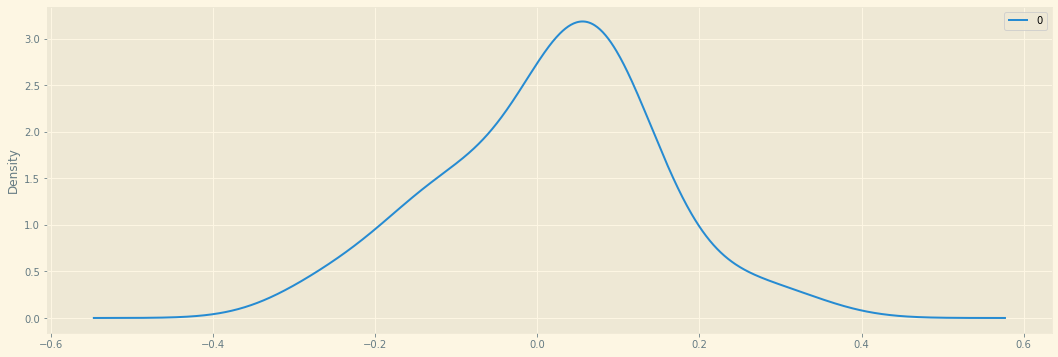

In [15]:
# split into train and test sets
X = data.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

# walk-forward validation
predictions_513 = []
for t in range(len(test)):
    model_513 = ARIMA(history, order=(5,1,3))
    fit_513 = model_513.fit()
    output = fit_513.forecast()
    yhat = output[0]
    predictions_513.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

#residuals describe
residuals_513 = [test[i]-predictions_513[i] for i in range(len(test))]
residuals_513 = pd.DataFrame(residuals_513)
print(residuals_513.describe())

residuals_513.plot(kind='kde')

fit_513.summary()

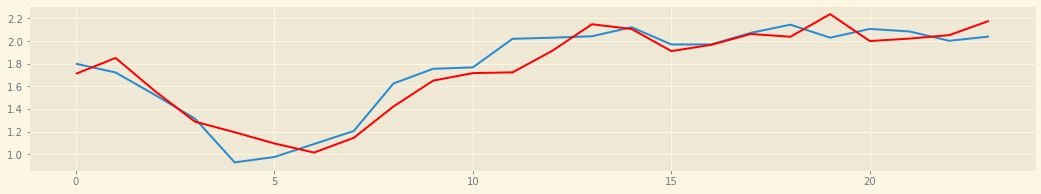

In [16]:
# plot forecasts against actual outcomes
plt.rc('figure', figsize=(18, 3))
plt.plot(test)
plt.plot(predictions_513, color='red')

# Тестирование ARIMA(6,2,7)

               0
count  24.000000
mean   -0.004186
std     0.127838
min    -0.340793
25%    -0.078709
50%    -0.003376
75%     0.063836
max     0.252305


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   67
Model:                 ARIMA(6, 2, 7)   Log Likelihood                  47.169
Date:                Mon, 01 Feb 2021   AIC                            -66.337
Time:                        10:15:22   BIC                            -35.896
Sample:                             0   HQIC                           -54.326
                                 - 67                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9795      0.390     -2.514      0.012      -1.743      -0.216
ar.L2         -0.9990      0.480     -2.080      0.038      -1.941      -0.057
ar.L3         -0.4571      0.507     -0.901      0.368      -1.451       0.537
ar.L4         -0.5765      0.435     -1.324      0.186      -1.430       0.277
ar.L5         -0.5889      0.338     -1.741      0.082      -1.252       0.074
ar.L6         -0.2079      0.285     -0.731      0.465      -0.766       0.350
ma.L1          0.4051     30.246      0.013      0.989     -58.877      59.687
ma.L2          0.6295     18.302      0.034      0.973     -35.242      36.501
ma.L3         -0.4964     36.943     -0.013      0.989     -72.904      71.911
ma.L4         -1.0820     52.619     -0.021      0.984    -104.214     102.050
ma.L5         -0.3514     19.339     -0.018      0.986     -38.255      37.552
ma.L6         -0.5403     30.133     -0.018      0.986     -59.601      58.520
ma.L7          0.4491     13.946      0.032      0.974     -26.884      27.783
sigma2         0.0105      0.321      0.033      0.974      -0.619       0.640
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.67   Prob(JB):                         0.93
Heteroskedasticity (H):               0.89   Skew:                            -0.05
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

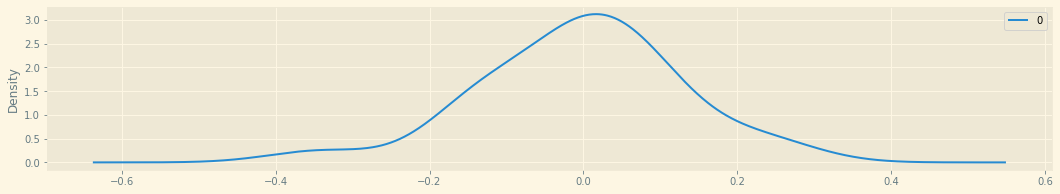

In [17]:
# split into train and test sets
X = data.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

# walk-forward validation
predictions_627 = []
for t in range(len(test)):
    model_627 = ARIMA(history, order=(6,2,7))
    fit_627 = model_627.fit()
    output = fit_627.forecast()
    yhat = output[0]
    predictions_627.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

#residuals describe
residuals_627 = [test[i]-predictions_627[i] for i in range(len(test))]
residuals_627 = pd.DataFrame(residuals_627)
print(residuals_627.describe())

residuals_627.plot(kind='kde')

fit_627.summary()

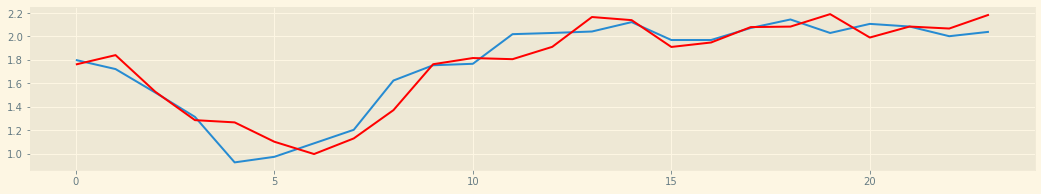

In [18]:
# plot forecasts against actual outcomes
plt.rc('figure', figsize=(18, 3))
plt.plot(test)
plt.plot(predictions_627, color='red')

# Forcast

In [19]:
# X = data.values
# model = ARIMA(X, order=(0,1,4))
# res_014 = model.fit()
# forecast_014 = res_014.forecast(steps=10)
# print(forecast_014)
# forc_014 = pd.DataFrame(forecast_015)
# forc_014.index = range(2021,2031)
# forc_014 = forc_014.rename(columns={0: 'W_temp_year'}, errors='raise')
# forc_014.plot()

# Forecast with ARIMA(6,2,7)

[1.89147045 1.82028111 1.85288513 1.92015543 1.95040561 1.97834163
 1.92738371 1.8965801  1.8894205  1.90065792]


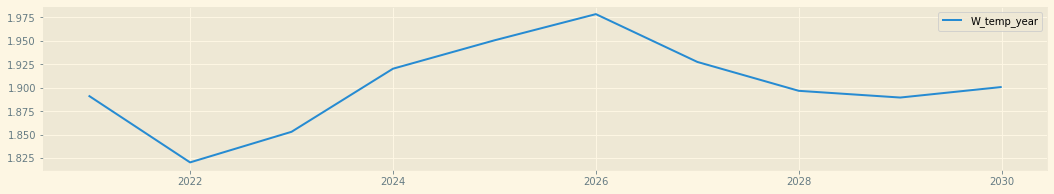

In [20]:
X = data.values
model = ARIMA(X, order=(5,1,3))
res_513 = model.fit()
forecast_513 = res_513.forecast(steps=10)
print(forecast_513)
forc_513 = pd.DataFrame(forecast_513)
forc_513.index = range(2021,2031)
forc_513 = forc_513.rename(columns={0: 'W_temp_year'}, errors='raise')
forc_513.plot()

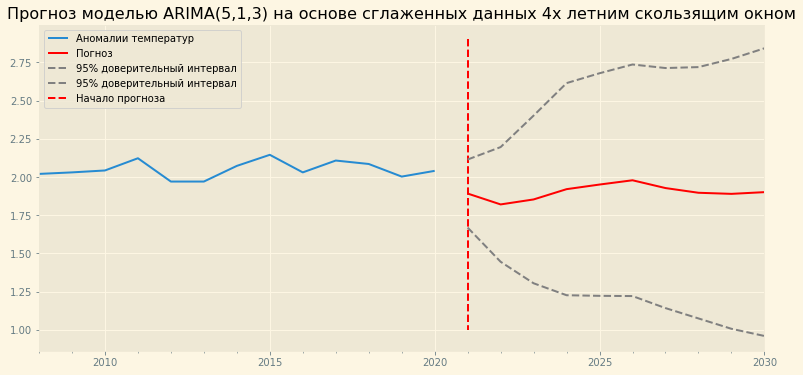

In [21]:
conf_int = res_513.get_forecast(steps=10)
conf_int = conf_int.conf_int()
forc_513['conf_down'] = [x[0] for x in conf_int]
forc_513['conf_up'] = [x[1] for x in conf_int]

forc_513.index = pd.to_datetime(forc_513.index, format='%Y')
temp = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(13,6), )
temp.rolling_data[55:].plot(ax=ax, label='Аномалии температур')
forc_513.W_temp_year.plot(ax=ax, color='red', label='Погноз')
forc_513.conf_down.plot(ax=ax, color='grey', linestyle='--', label='95% доверительный интервал')
forc_513.conf_up.plot(ax=ax,  color='grey', linestyle='--', label='95% доверительный интервал')
ax.vlines('2021-01-01', 2.9, 1, linestyle='--', color='r', label='Начало прогноза')
plt.title('Прогноз моделью ARIMA(5,1,3) на основе сглаженных данных 4х летним скользящим окном')
plt.legend()

#  Forecast with ARIMA(6,2,7)

[1.89111298 1.8062771  1.88734523 1.98875929 1.99898752 2.09249828
 2.04780035 1.98535838 2.04172696 2.04713106]


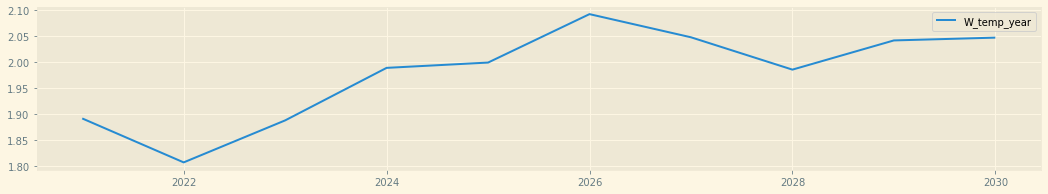

In [22]:
X = data.values
model = ARIMA(X, order=(6,2,7))
res_627 = model.fit()
forecast_627 = res_627.forecast(steps=10)
print(forecast_627)
forc_627 = pd.DataFrame(forecast_627)
forc_627.index = range(2021,2031)
forc_627 = forc_627.rename(columns={0: 'W_temp_year'}, errors='raise')
forc_627.plot()

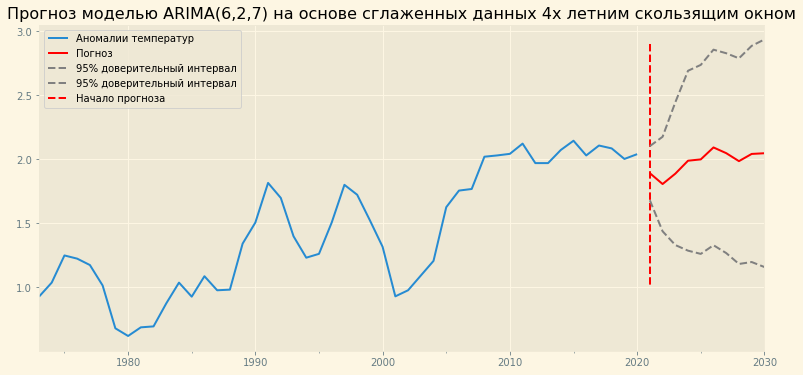

In [23]:
conf_int = res_627.get_forecast(steps=10)
conf_int = conf_int.conf_int()
forc_627['conf_down'] = [x[0] for x in conf_int]
forc_627['conf_up'] = [x[1] for x in conf_int]

forc_627.index = pd.to_datetime(forc_627.index, format='%Y')
#temp = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(13,6), )
temp.rolling_data[20:].plot(ax=ax, label='Аномалии температур')
forc_627.W_temp_year.plot(ax=ax, color='red', label='Погноз')
forc_627.conf_down.plot(ax=ax, color='grey', linestyle='--', label='95% доверительный интервал')
forc_627.conf_up.plot(ax=ax,  color='grey', linestyle='--', label='95% доверительный интервал')
ax.vlines('2021-01-01', 2.9, 1, linestyle='--', color='r', label='Начало прогноза')
plt.title('Прогноз моделью ARIMA(6,2,7) на основе сглаженных данных 4х летним скользящим окном')
plt.legend()

NameError: name 'res_014' is not defined

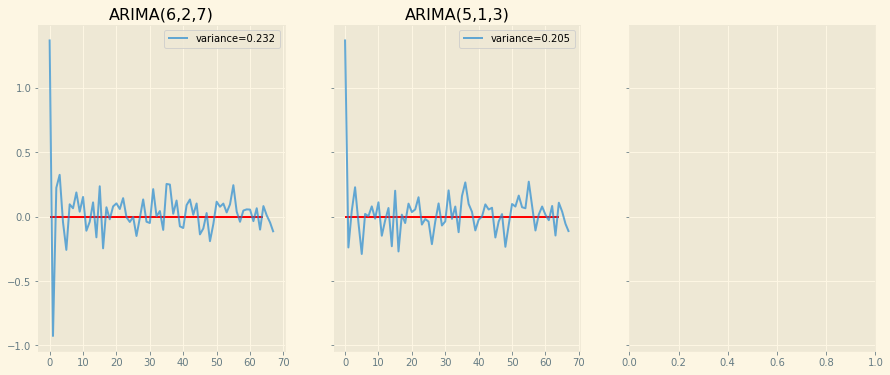

In [24]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(15, 6))
ax[0].plot(res_627.resid, alpha=0.7, label='variance={:.3f}'.format(np.std(res_627.resid)));
ax[0].hlines(0, xmin=0, xmax=64, color='r');
ax[0].set_title("ARIMA(6,2,7)");
ax[0].legend();
ax[1].plot(res_513.resid, alpha=0.7, label='variance={:.3f}'.format(np.std(res_513.resid)));
ax[1].hlines(0, xmin=0, xmax=64, color='r');
ax[1].set_title("ARIMA(5,1,3)");
ax[1].legend();
ax[2].plot(res_014.resid, alpha=0.7, label='variance={:.3f}'.format(np.std(res_014.resid)));
ax[2].hlines(0, xmin=0, xmax=64, color='r');
ax[2].set_title("ARIMA(0,1,5)");
ax[2].legend();

fig, ax = plt.subplots(2,3, figsize=(15,6))
ax[0,0] = plot_acf(res_627.resid, lags=20, title='ARIMA(6,2,7)', ax=ax[0,0])
ax[1,0] = plot_pacf(res_627.resid, ax=ax[1, 0], lags=20, title="PACF")
ax[0,1] = plot_acf(res_513.resid, lags=20, title='ARIMA(5,1,3)', ax=ax[0,1])
ax[1,1] = plot_pacf(res_513.resid, ax=ax[1, 1], lags=20, title="PACF")
ax[0,2] = plot_acf(res_014.resid, lags=20, title='ARIMA(0,1,4)', ax=ax[0,2])
ax[1,2] = plot_pacf(res_014.resid, ax=ax[1, 2], lags=20, title="PACF")

In [44]:
# save test-predictions to exel

train_model = pd.DataFrame({
    'test': test,
    'Arima(5,1,3)': predictions_513,
    'Arima(6,2,7)': predictions_627
},
    index=(range(1997,2021)))
train_model = train_model.round(2)
train_model

forc_513 = forc_513.round(2)
forc_627 = forc_627.round(2)

with pd.ExcelWriter('ARIMA_with_rolling_mean.xlsx') as writer:
    train_model.to_excel(writer, sheet_name='тесты модели', engine='xlsxwriter')
    forc_513.to_excel(writer, sheet_name='прогноз_ARIMA(5,1,3)', engine='xlsxwriter')
    forc_627.to_excel(writer, sheet_name='прогноз_ARIMA(6,2,7)', engine='xlsxwriter')
